## Modeling Experimentation
### Multitask NN

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras import layers, models, Input
import matplotlib.pyplot as plt
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score, classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras import backend as K


In [8]:
df = pd.read_parquet('../data/cleaned_output.parquet')
print(df.head())

        age    num.co       edu     scoma   charges    totcst   totmcst  \
0  0.012772 -1.390013 -0.216878 -0.489482 -0.489861 -0.692506 -0.295581   
1 -0.148262  0.097711  0.073186  1.296570 -0.248432 -0.245583 -0.204598   
2 -0.635153  0.097711  0.073186 -0.489482 -0.184151 -0.134768  0.012527   
3 -1.299688  0.097711 -0.216878 -0.489482 -0.554551 -0.722077 -0.758912   
4  1.105258 -0.646151  0.003856  0.565913 -0.096147 -0.104282 -0.026113   

    avtisst       sps       aps  ...  race_black  race_hispanic  race_other  \
0 -1.179740  0.845813 -0.884198  ...   -0.424643      -0.181379    8.960728   
1  0.482831  2.744711  1.828994  ...   -0.424643      -0.181379   -0.111598   
2 -0.726312 -0.507724  0.371909  ...   -0.424643      -0.181379   -0.111598   
3 -1.179740 -0.548369 -0.934442  ...   -0.424643      -0.181379   -0.111598   
4 -0.298074 -0.204658 -0.381755  ...   -0.424643      -0.181379   -0.111598   

   race_white     ca_no    ca_yes  dnr_dnr before sadm  dnr_no dnr  death 

In [9]:
# Assuming df with features and two binary targets: 'death' and 'hospital_death'
X = df.drop(columns=['death', 'hospdead'])
y_death = df['death']
y_hosp_death = df['hospdead']

# Train/test split
X_train, X_test, y_train_death, y_test_death, y_train_hosp, y_test_hosp = train_test_split(
    X, y_death, y_hosp_death, test_size=0.2, stratify=y_death, random_state=42)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [64]:
input_dim = X_train_scaled.shape[1]

inputs = Input(shape=(input_dim,))

# Shared hidden layers with dropout and L2
x = layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001))(inputs)
x = layers.Dropout(0.3)(x)
x = layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.001))(x)
x = layers.Dropout(0.3)(x)

# Output layers for each task
death_output = layers.Dense(1, activation='sigmoid', name='death')(x)
hospital_death_output = layers.Dense(1, activation='sigmoid', name='hospital_death')(x)

model = models.Model(inputs=inputs, outputs=[death_output, hospital_death_output])

model.compile(
    optimizer='adam',
    loss={
        'death': 'binary_crossentropy',
        'hospital_death': 'binary_crossentropy'
    },
    loss_weights={
        'death': 2.0,               # Prioritize 'death'
        'hospital_death': 1.0       # Less emphasis on 'hospital_death'
    },
    metrics={
        'death': 'AUC',
        'hospital_death': 'AUC'
    }
)

model.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5       │ (None, 57)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_10 (Dense)    │ (None, 64)        │      3,712 │ input_layer_5[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_8 (Dropout) │ (None, 64)        │          0 │ dense_10[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_11 (Dense)    │ (None, 32)        │      2,080 │ dropout_8[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_9 (Dropout) │ (None, 32)        │          0 │ dense_11[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ death (Dense)       │ (None, 1)         │         33 │ dropout_9[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ hospital_death      │ (None, 1)         │         33 │ dropout_9[0][0]   │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 5,858 (22.88 KB)

 Trainable params: 5,858 (22.88 KB)

 Non-trainable params: 0 (0.00 B)

In [65]:
# adding callback 
callbacks = [
    EarlyStopping(patience=3, monitor='val_loss', restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2)
]

In [66]:
# training
history = model.fit(
    X_train_scaled,
    {'death': y_train_death, 'hospital_death': y_train_hosp},
    validation_split=0.2,
    epochs=50,
    batch_size=32,
    callbacks=callbacks
)

Epoch 1/50
183/183 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - death_AUC: 0.6553 - death_loss: 0.6180 - hospital_death_AUC: 0.7165 - hospital_death_loss: 0.5438 - loss: 1.8811 - val_death_AUC: 0.8236 - val_death_loss: 0.4689 - val_hospital_death_AUC: 0.9217 - val_hospital_death_loss: 0.3199 - val_loss: 1.3587 - learning_rate: 0.0010
Epoch 2/50
183/183 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - death_AUC: 0.7699 - death_loss: 0.5275 - hospital_death_AUC: 0.8989 - hospital_death_loss: 0.3437 - loss: 1.4962 - val_death_AUC: 0.8377 - val_death_loss: 0.4562 - val_hospital_death_AUC: 0.9324 - val_hospital_death_loss: 0.2916 - val_loss: 1.3016 - learning_rate: 0.0010
Epoch 3/50
183/183 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - death_AUC: 0.8104 - death_loss: 0.4895 - hospital_death_AUC: 0.9186 - hospital_death_loss: 0.3087 - loss: 1.3819 - val_death_AUC: 0.8418 - val_death_loss: 0.4491 - val_hospital_death_AUC: 0.9378 - val_hospital_death_loss: 0.2785 - val_loss: 1.2713 - learning_rate: 0.0010
Epoch 4/50
183/183

In [67]:
eval_results = model.evaluate(X_test_scaled, {'death': y_test_death, 'hospital_death': y_test_hosp}, verbose=2)
print(f"Test Loss and AUC: {eval_results}")

57/57 - 1s - 10ms/step - death_AUC: 0.8533 - death_loss: 0.4354 - hospital_death_AUC: 0.9508 - hospital_death_loss: 0.2442 - loss: 1.1862
Test Loss and AUC: [1.1862363815307617, 0.43544721603393555, 0.24416598677635193, 0.8533424139022827, 0.9507505297660828]


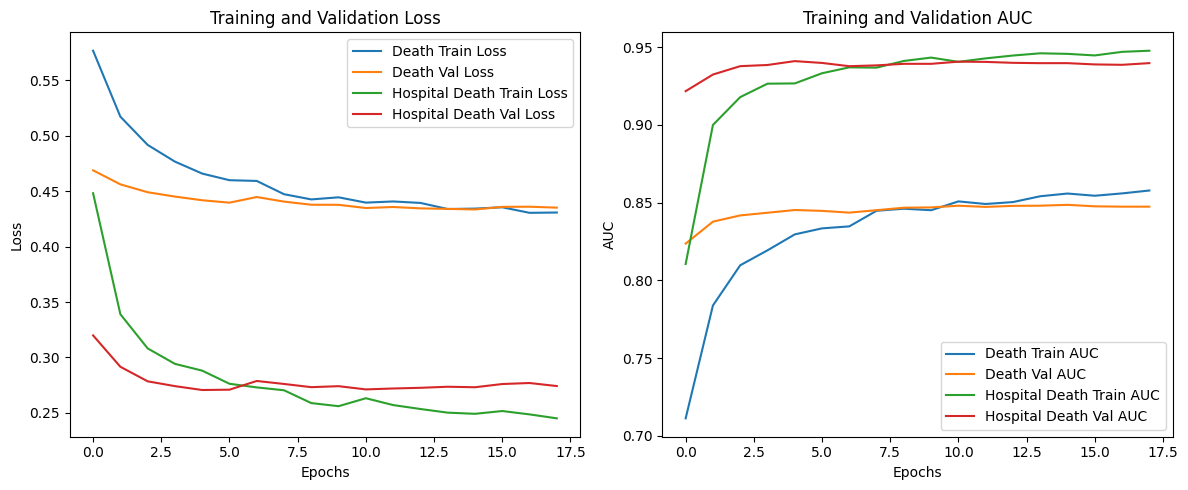

In [68]:
# history is the object returned by model.fit()
history_dict = history.history

# Plot training & validation loss for both tasks
plt.figure(figsize=(12, 5))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(history_dict['death_loss'], label='Death Train Loss')
plt.plot(history_dict['val_death_loss'], label='Death Val Loss')
plt.plot(history_dict['hospital_death_loss'], label='Hospital Death Train Loss')
plt.plot(history_dict['val_hospital_death_loss'], label='Hospital Death Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# AUC plot (if you tracked it)
plt.subplot(1, 2, 2)
plt.plot(history_dict['death_AUC'], label='Death Train AUC')
plt.plot(history_dict['val_death_AUC'], label='Death Val AUC')
plt.plot(history_dict['hospital_death_AUC'], label='Hospital Death Train AUC')
plt.plot(history_dict['val_hospital_death_AUC'], label='Hospital Death Val AUC')
plt.xlabel('Epochs')
plt.ylabel('AUC')
plt.title('Training and Validation AUC')
plt.legend()

plt.tight_layout()
plt.show()

In [69]:
# accuracy

pred_probs = model.predict(X_test_scaled)

# Since it's multi-output, you get a list of arrays
pred_death = pred_probs[0]  # shape (num_samples, 1)
pred_hospital = pred_probs[1]  # shape (num_samples, 1)

pred_death_binary = (pred_death > 0.5).astype(int)
pred_hospital_binary = (pred_hospital > 0.5).astype(int)

57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


In [ ]:
# Death
print("DEATH TASK METRICS")
print("Accuracy:", accuracy_score(y_test_death, pred_death_binary))
print("AUC:", roc_auc_score(y_test_death, pred_death))
print("Precision:", precision_score(y_test_death, pred_death_binary)) 
print("Recall:", recall_score(y_test_death, pred_death_binary))
print(classification_report(y_test_death, pred_death_binary))

# Hospital Death
print("\nHOSPITAL DEATH TASK METRICS")
print("Accuracy:", accuracy_score(y_test_hosp, pred_hospital_binary))
print("AUC:", roc_auc_score(y_test_hosp, pred_hospital))
print("Precision:", precision_score(y_test_hosp, pred_hospital_binary)) 
print("Recall:", recall_score(y_test_hosp, pred_hospital_binary))
print(classification_report(y_test_hosp, pred_hospital_binary))

DEATH TASK METRICS
Accuracy: 0.7880285557386052
AUC: 0.8534964743767697
Precision: 0.8148967551622419
Recall: 0.8911290322580645
              precision    recall  f1-score   support

           0       0.71      0.57      0.63       581
           1       0.81      0.89      0.85      1240

    accuracy                           0.79      1821
   macro avg       0.76      0.73      0.74      1821
weighted avg       0.78      0.79      0.78      1821


HOSPITAL DEATH TASK METRICS
Accuracy: 0.9011532125205931
AUC: 0.9508768232935336
Precision: 0.8172268907563025
Recall: 0.8070539419087137
              precision    recall  f1-score   support

           0       0.93      0.94      0.93      1339
           1       0.82      0.81      0.81       482

    accuracy                           0.90      1821
   macro avg       0.87      0.87      0.87      1821
weighted avg       0.90      0.90      0.90      1821



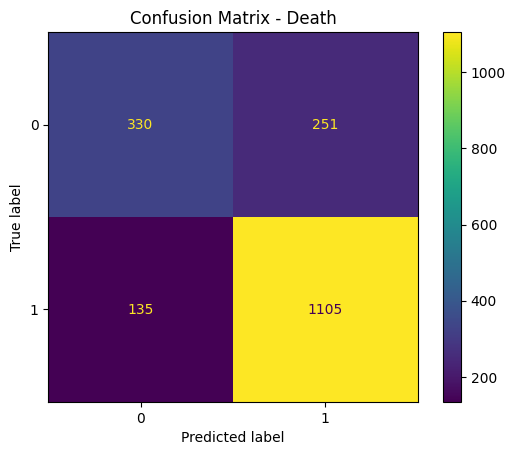

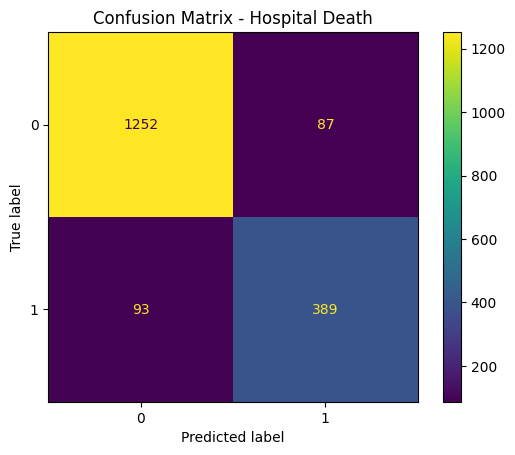

In [71]:
# Death
cm_death = confusion_matrix(y_test_death, pred_death_binary)
ConfusionMatrixDisplay(cm_death, display_labels=[0, 1]).plot()
plt.title("Confusion Matrix - Death")
plt.show()

# Hospital Death
cm_hosp = confusion_matrix(y_test_hosp, pred_hospital_binary)
ConfusionMatrixDisplay(cm_hosp, display_labels=[0, 1]).plot()
plt.title("Confusion Matrix - Hospital Death")
plt.show()

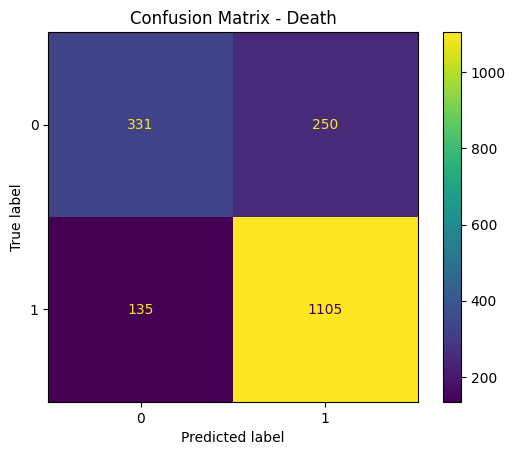

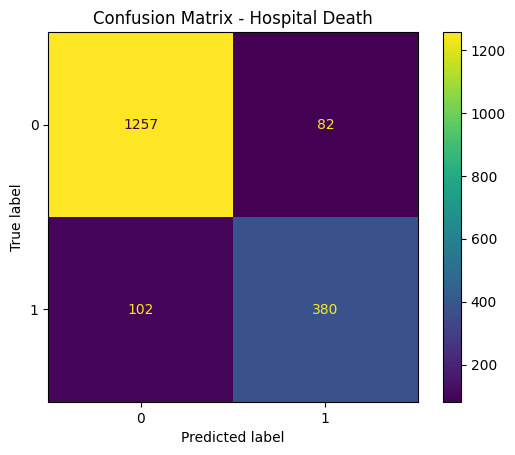

In [48]:
# Death
cm_death = confusion_matrix(y_test_death, pred_death_binary)
ConfusionMatrixDisplay(cm_death, display_labels=[0, 1]).plot()
plt.title("Confusion Matrix - Death")
plt.show()

# Hospital Death
cm_hosp = confusion_matrix(y_test_hosp, pred_hospital_binary)
ConfusionMatrixDisplay(cm_hosp, display_labels=[0, 1]).plot()
plt.title("Confusion Matrix - Hospital Death")
plt.show()